# Introduction
In this notebook I build on the work of the author changing his original code as well as adding some additional examples to learn how to use an example of an unsupervised deep learning neural network..<br>
Source: <a href="https://github.com/trekhleb/machine-learning-experiments/blob/master/experiments/clothes_generation_dcgan/clothes_generation_dcgan.ipynb">Github</a><br>
The original text by the author is written in gray to improve readability<br>
Support: used chatgpt and github copilot

# Change Log
Summary of the changes made:
<ol>
    <li>All the comments started with ## were added by me</li>
    <li>Added markdowns to explain certain sections</li>
    <li>Grayed out the authors text</li>
</ol>

# <span style="color: grey;">Generating Images of Clothes Using Deep Convolutional Generative Adversarial Network (DCGAN)

> - <span style="color: grey;">🤖 See [full list of Machine Learning Experiments](https://github.com/trekhleb/machine-learning-experiments) on **GitHub**<br/><br/>
> - <span style="color: grey;">▶️ **Interactive Demo**: [try this model and other machine learning experiments in action](https://trekhleb.github.io/machine-learning-experiments/)

## <span style="color: grey;">Experiment overview

<span style="color: grey;">In this experiment we will generate images of clothing using a [Deep Convolutional Generative Adversarial Network](https://arxiv.org/pdf/1511.06434.pdf) (DCGAN). The code is written using the [Keras Sequential API](https://www.tensorflow.org/guide/keras) with a [tf.GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape) training loop. For training we will be using Fashion [MNIST dataset](https://www.tensorflow.org/datasets/catalog/fashion_mnist).

<span style="color: grey;">A **generative adversarial network** (GAN) is a class of machine learning frameworks. Two neural networks contest with each other in a game. Two models are trained simultaneously by an adversarial process. A generator ("the artist") learns to create images that look real, while a discriminator ("the art critic") learns to tell real images apart from fakes.

<span style="color: grey;">![clothes_generation_dcgan.jpg](../../demos/src/images/clothes_generation_dcgan.jpg)

<span style="color: grey;">Inspired by: [Deep Convolutional Generative Adversarial Network](https://www.tensorflow.org/tutorials/generative/dcgan) tutorial.

## <span style="color: grey;">Importing dependencies

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import math
import datetime
import platform
import imageio
import PIL
import time
import os
import glob
import zipfile

from IPython import display

print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.11.9
Tensorflow version: 2.18.0
Keras version: 3.8.0


The function below is used to check whether eager execution is turned on. Eager execution is an environment in TensorFlow where operations are ran as soon as it tf is executed. It makes debugging simpler. 

In [4]:
# Checking the eager execution availability.
tf.executing_eagerly()

True

## <span style="color: grey;">Loading the data

The dataset below is imported from TensorFlow dataset library

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [7]:
print('x_train.shape: ', x_train.shape)
print('y_train.shape: ', y_train.shape)
print()
print('x_test.shape: ', x_test.shape)
print('y_test.shape: ', y_test.shape)

x_train.shape:  (60000, 28, 28)
y_train.shape:  (60000,)

x_test.shape:  (10000, 28, 28)
y_test.shape:  (10000,)


Since GAN is an unsupervised model there is no need for a train/test split, so both splits are concatenated.

In [8]:
# Since we don't need test examples we may concatenate both sets
x_train = np.concatenate((x_train, x_test), axis=0)

print('x_train.shape: ', x_train.shape)

x_train.shape:  (70000, 28, 28)


The dataset x valuesa are 70,000 images 28x28 pixels

In [9]:
TOTAL_EXAMPLES_NUM = x_train.shape[0]

print('TOTAL_EXAMPLES_NUM: ', TOTAL_EXAMPLES_NUM)

TOTAL_EXAMPLES_NUM:  70000


In [10]:
print('y_train[0] =', y_train[0])

y_train[0] = 9


<span style="color: grey;">Here are the map of classes for the dataset according to [documentation](https://github.com/zalandoresearch/fashion-mnist):

<table style="color: grey;">
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

In [11]:
class_names = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
]

## <span style="color: grey;">Analyzing the dataset

Below you can see how the images are represented in the dataset

In [12]:
print(x_train[0])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1   1   0 200 232 23

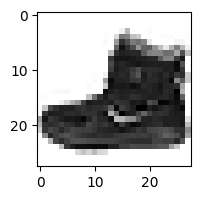

In [13]:
plt.figure(figsize=(2, 2))
plt.imshow(x_train[0], cmap=plt.cm.binary)
plt.show()

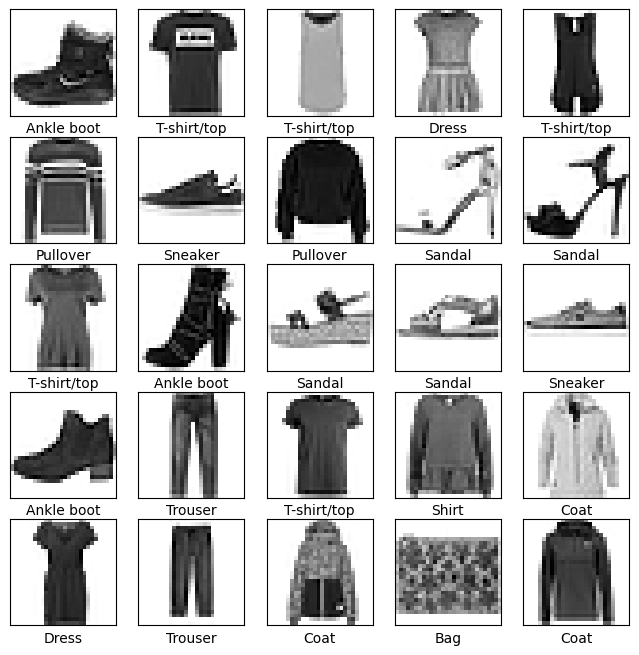

In [14]:
numbers_to_display = 25
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize=(8, 8))
for i in range(numbers_to_display):
    plt.subplot(num_cells, num_cells, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

## <span style="color: grey;">Reshape and normalize data

Here the data is reshaped so it would the expected format for GAN which expects you to input: number of images, height, width and channels. The channels represent the colors for the images since it is grayscale it will only be 1.

In [15]:
x_train_reshaped = x_train.reshape(
    x_train.shape[0],
    x_train.shape[1],
    x_train.shape[2],
    1
).astype('float32')

In [16]:
print('x_train_reshaped.shape: ', x_train_reshaped.shape)

x_train_reshaped.shape:  (70000, 28, 28, 1)


Here the data is normalised which means the values for each image are scaled to be within -1 and 1. This makes it easier for the model to process.

In [17]:
# Normalize image pixel values to [-1, 1] range
x_train_normalized = (x_train_reshaped - 127.5) / 127.5

In [18]:
print('Normalized data values:\n')
print(x_train_normalized[0,:,:,0])

Normalized data values:

[[-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1. 

## <span style="color: grey;">Creating a batched dataset

The dataset is organised into batches to allow the dataset to be processed in smaller incraments.

In [19]:
SHUFFLE_BUFFER_SIZE = TOTAL_EXAMPLES_NUM
BATCH_SIZE = 1024 ## 1024 samples processed in a single step

## epochs = a complete iteration through the dataset
## TRAINING_STEPS_PER_EPOCH = number of batches needed to process all samples in the dataset
TRAINING_STEPS_PER_EPOCH = math.ceil(TOTAL_EXAMPLES_NUM / BATCH_SIZE) 

print('BATCH_SIZE: ', BATCH_SIZE)
print('TRAINING_STEPS_PER_EPOCH: ', TRAINING_STEPS_PER_EPOCH)

BATCH_SIZE:  1024
TRAINING_STEPS_PER_EPOCH:  69


In [20]:
## Here a tf.data.Dataset object is created from the normalized data
train_dataset = tf.data.Dataset.from_tensor_slices(x_train_normalized) \
    .shuffle(SHUFFLE_BUFFER_SIZE) \
    .batch(BATCH_SIZE)

print(train_dataset)

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>


## <span style="color: grey;">Create models

Here the 2 models are created for GAN. These 2 models compete to find flaws within each other<br>
<strong>Generator</strong> - Creates fake images to try to fool the discriminator<br>
<strong>Discriminator</strong> - Tries to detect those fake images<br>
Both models improve each other over time.

### <span style="color: grey;">Create generator

In [21]:
def make_generator_model():
    ## Creates empty model, layers are added using .add() method
    model = tf.keras.Sequential()
    
    # Step 1.
    ## Adds a dense layer with 7*7*256 units and no bias
    ## Input shape is 100-dimensional vector
    model.add(tf.keras.layers.Dense(
        units=7*7*256,
        use_bias=False,
        input_shape=(100,)
    ))
    ## Adds a batch normalization layer
    ## batch normalization is used to normalize each batches activations from the previous layer
    model.add(tf.keras.layers.BatchNormalization())
    ## Adds a Leaky ReLU activation function
    model.add(tf.keras.layers.LeakyReLU())
    
    # Step 2.
    ## Reshapes the output of the previous layer to a 3D tensor
    model.add(tf.keras.layers.Reshape((7, 7, 256)))
    ## Asserts the shape of the output tensor
    assert model.output_shape == (None, 7, 7, 256) # None is a batch size.
    
    # Step 3.
    ## Adds a convolutional layer with 128 filters, kernel size 5x5, stride 1x1, 
    ## same padding and no bias
    ## convolutional layers are used to detect patterns in the input data
    model.add(tf.keras.layers.Conv2DTranspose(
        filters=128,
        kernel_size=(5, 5),
        strides=(1, 1),
        padding='same',
        use_bias=False
    ))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    # Step 4.
    ## Adds a convolutional layer
    model.add(tf.keras.layers.Conv2DTranspose(
        filters=64,
        kernel_size=(5, 5),
        strides=(2, 2),
        padding='same',
        use_bias=False
    ))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    
    # Step 5.
    ## Adds a convolutional layer
    model.add(tf.keras.layers.Conv2DTranspose(
        filters=1,
        kernel_size=(5, 5),
        strides=(2, 2),
        padding='same',
        use_bias=False,
        activation='tanh'
    ))
    assert model.output_shape == (None, 28, 28, 1)
    
    return model

In [22]:
generator_model = make_generator_model()

C:\Users\C00273530\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Below you can see the details about each of the layers in this model.

In [23]:
generator_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12544)          │     1,254,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 7, 7, 128)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │         1,600 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

In [39]:
tf.keras.utils.plot_model(
    generator_model,
    show_shapes=True,
    show_layer_names=True,
    to_file='generator_model.png'
)

You must install pydot (`pip install pydot`) for `plot_model` to work.


Below a random noisy image is generated.

In [29]:
noise = tf.random.normal(shape=[1, 100])

print(noise.numpy())

[[-0.08176491 -0.39466682  0.7248894  -0.5521628   0.19552459  0.5342799
  -0.715257   -1.4887114   1.0034065   0.15670958  0.81429815 -0.8256705
  -0.7667636  -1.2179469   0.6491949   1.1945672   1.949831    0.31811136
  -0.21387109  0.21190149  1.239795   -0.38445947 -0.2043431  -0.8591396
  -0.10379134  0.4432786  -0.3468397   0.12352414 -0.39108178 -0.6035718
  -0.95834047 -0.2971202  -0.8646809   0.42842773 -1.1606739  -0.9514859
   0.70431805 -0.1674747  -0.11081832  0.85496044 -0.10257103 -1.4381454
  -0.7122577  -0.32219806  0.67119044  0.1558856  -0.9339475  -1.1155318
   0.42440253  1.0010216   0.39071757 -0.59612066 -0.54504883  1.7337288
   1.6151047   0.8752329  -0.36576325 -1.532064    0.2684395  -0.12856883
   0.1864118  -2.2149255   1.4974926   0.8716456   0.57612544 -1.4134815
  -0.2871107  -0.05520532  3.1183133  -0.288712    1.8191293  -0.54235345
   0.5963407  -0.0831496   0.04854141  0.286134   -1.621794    0.35224825
   0.5338337   0.55183923  0.25741398 -0.811781

In [30]:
generated_image = generator_model(noise, training=False)

print('generated_image.shape: ', generated_image.shape)

generated_image.shape:  (1, 28, 28, 1)


In [31]:
print(generated_image[0, :, :, 0].numpy())

[[ 3.16022919e-03 -4.62961994e-04 -1.25583296e-03  2.89153238e-03
   4.21793805e-03  1.11799128e-03 -1.50483381e-03 -1.47090177e-04
  -2.79191555e-03 -5.27269952e-03 -4.11654077e-03  6.09819195e-04
   4.40385984e-03  1.23848149e-04 -5.05555375e-03 -1.13248052e-02
  -7.44030671e-03  1.01755476e-02  2.60982825e-03 -9.72796115e-04
   8.12304486e-03 -3.06069897e-03  3.74817784e-04 -4.32674913e-03
  -4.02731384e-04  2.69650249e-04 -4.63612331e-03  2.19455175e-03]
 [ 6.75210170e-03  7.10747857e-03  6.94167661e-03  2.59616110e-03
  -3.07849678e-03  1.78095419e-02 -6.96470449e-03 -6.36418629e-03
   2.33163545e-03 -1.73077465e-03  7.22397817e-03  5.33194607e-03
  -3.12950904e-03 -6.75177341e-03 -4.36776131e-03  1.55846244e-02
   5.33784367e-03  2.95915152e-03  4.79092996e-04  4.78050963e-04
   1.48015898e-02 -4.03766520e-03 -1.17587904e-02 -1.35941757e-03
  -3.82960099e-03  2.39612199e-02  1.11344904e-02  8.19885265e-03]
 [-2.06848071e-03 -2.03237240e-03  9.43856954e-04 -6.75818603e-03
   3.948

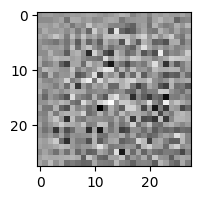

In [32]:
plt.figure(figsize=(2, 2))
plt.imshow(generated_image[0, :, :, 0], cmap=plt.cm.binary)

### <span style="color: grey;">Create discriminator

<span style="color: grey;">The model will be trained to output positive values for real images, and negative values for fake images.

In [44]:
def make_discriminator_model():
    ## Creates empty model, layers are added using .add() method
    model = tf.keras.Sequential()
    
    # Step 1.
    ## Adds a convolutional layer with 64 filters, kernel size 5x5, stride 2x2,
    ## same padding and input shape 28x28x1
    model.add(tf.keras.layers.Conv2D(
        filters=64,
        kernel_size=(5, 5),
        strides=(2, 2),
        padding='same',
        input_shape=[28, 28, 1]
    ))
    ## Adds a Leaky ReLU activation function
    model.add(tf.keras.layers.LeakyReLU())
    ## Adds a dropout layer
    ## Prevents overfitting
    model.add(tf.keras.layers.Dropout(0.3))
    
    # Step 2.
    ## Adds a convolutional layer
    model.add(tf.keras.layers.Conv2D(
        filters=128,
        kernel_size=(5, 5),
        strides=(2, 2),
        padding='same'
    ))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))
    
    # Step 3.
    ## Flattens the output of the previous layer
    ## Flattens into a 1D vector
    model.add(tf.keras.layers.Flatten())
    
    # Real vs Fake
    ## Adds a single neuron that will return a value between 0 and 1
    ## 0 - fake image
    ## 1 - real image
    model.add(tf.keras.layers.Dense(1))
    
    return model

The breakdown of the different layers in the model are below

In [34]:
discriminator_model = make_discriminator_model()

C:\Users\C00273530\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [46]:
discriminator_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
tf.keras.utils.plot_model(
    discriminator_model,
    show_shapes=True,
    show_layer_names=True,
    to_file='discriminator_model.png'
)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [48]:
dicision = discriminator_model(generated_image)

print(dicision)

tf.Tensor([[-0.00109528]], shape=(1, 1), dtype=float32)


The generated image from above is passed into the discriminator and is correctly identified as fake.

## <span style="color: grey;">Define the loss and optimizers

### <span style="color: grey;">Discriminator loss

<span style="color: grey;">This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [49]:
def discriminator_loss(real_output, fake_output):
    ## cross_entropy is set a as a loss function used to calculate the loss on binary classification 
    ## tasks
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    
    ## Below the loss is calculated for the real images
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    ## Below the loss is calculated for the fake images
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    ## Below the total loss is calculated
    total_loss = real_loss + fake_loss
    
    return total_loss

Here 4 test cases are passed into the function to check the outpus under certain scenarios. 

In [52]:
# Test discriminator loss function.
output_combinations = [
    (tf.constant([-1.], dtype=tf.float32), tf.constant([1.], dtype=tf.float32)),
    (tf.constant([1.], dtype=tf.float32), tf.constant([-1.], dtype=tf.float32)),
    (tf.constant([1.], dtype=tf.float32), tf.constant([0.], dtype=tf.float32)),
    (tf.constant([10.], dtype=tf.float32), tf.constant([-1.], dtype=tf.float32)),
]
for (real_output, fake_output) in output_combinations:
    loss = discriminator_loss(real_output, fake_output).numpy()
    print('Discriminator loss for:', real_output, fake_output)
    print('  REAL output:', real_output)
    print('  FAKE output:', fake_output)
    print('  loss: ', loss)
    print()

Discriminator loss for: tf.Tensor([-1.], shape=(1,), dtype=float32) tf.Tensor([1.], shape=(1,), dtype=float32)
  REAL output: tf.Tensor([-1.], shape=(1,), dtype=float32)
  FAKE output: tf.Tensor([1.], shape=(1,), dtype=float32)
  loss:  2.6265235

Discriminator loss for: tf.Tensor([1.], shape=(1,), dtype=float32) tf.Tensor([-1.], shape=(1,), dtype=float32)
  REAL output: tf.Tensor([1.], shape=(1,), dtype=float32)
  FAKE output: tf.Tensor([-1.], shape=(1,), dtype=float32)
  loss:  0.6265234

Discriminator loss for: tf.Tensor([1.], shape=(1,), dtype=float32) tf.Tensor([0.], shape=(1,), dtype=float32)
  REAL output: tf.Tensor([1.], shape=(1,), dtype=float32)
  FAKE output: tf.Tensor([0.], shape=(1,), dtype=float32)
  loss:  1.0064089

Discriminator loss for: tf.Tensor([10.], shape=(1,), dtype=float32) tf.Tensor([-1.], shape=(1,), dtype=float32)
  REAL output: tf.Tensor([10.], shape=(1,), dtype=float32)
  FAKE output: tf.Tensor([-1.], shape=(1,), dtype=float32)
  loss:  0.31330708



### <span style="color: grey;"> Generator loss

<span style="color: grey;">The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [53]:
def generator_loss(fake_output):
    ## cross_entropy is set a as a loss function used to calculate the loss on binary classification
    ## tasks
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    ## Below the loss is calculated for the fake images
    loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return loss

In [57]:
# Test generator loss function.
a = (tf.constant([5.], dtype=tf.float32))
b = (tf.constant([0.], dtype=tf.float32))
print('Generator loss for >1: ', generator_loss(a).numpy())
print('Generator loss for =0: ', generator_loss(b).numpy())

Generator loss for >1:  0.0067153485
Generator loss for =0:  0.6931472


### <span style="color: grey;">Optimizers

Optimizers are algorithms that dynamically update the model's parameters such as weights and biases. Below 2 adam optimizers are used for both the generator and discriminator. 

In [58]:
## The learning_rate is set to 0.0001 for both models which means that the weights will be updated
## by 0.0001 in each iteration
generator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0001
)

discriminator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0001
)

### <span style="color: grey;">Checkpoints

Checkpoints are saved states that you can use to pause or resume training from.

In [59]:
## The checkpoint_dir is set to './tmp/ckpt' which means that the checkpoints will be saved in the
## tmp folder in the current directory
checkpoint_dir = './tmp/ckpt'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator_model=generator_model,
    discriminator_model=discriminator_model
)

## <span style="color: grey;">Training

In [60]:
EPOCHS = 100 ## 100 Iterations
## Noise dimension is set to 100 which means that the input to the generator will be a 
## 100-dimensional vector
noise_dim = 100 
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
input_noise_seed = tf.random.normal([num_examples_to_generate, noise_dim])

<span style="color: grey;">The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [61]:
# This `tf.function` annotation causes the function to be "compiled".
# @tf.function
## This function represents a single step in the training process
def train_step(real_images):
    ## This dictionary will store the training history
    ## It'll store the loss for the discriminator and the generator at each step
    training_history = {
        'discriminator': {
            'loss': None
        },
        'generator': {
            'loss': None
        }
    }

    # Generate input noise.
    ## This noise is used as an input to the generator for fake images
    noise_images = tf.random.normal([BATCH_SIZE, noise_dim])
    
    ## Gradient Tape is like a notebook that sotres all the different gradients
    ## Gradients are used to update the weights of the models
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake images.
        generated_images = generator_model(
            noise_images,
            training=True
        )
        
        # Detect fake and real images.
        real_output = discriminator_model(
            real_images,
            training=True
        )
        fake_output = discriminator_model(
            generated_images,
            training=True
        )
        
        # Calculate losses.
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(
            real_output,
            fake_output
        )

        ## Saves the loss history for each
        training_history['discriminator']['loss'] = disc_loss.numpy()
        training_history['generator']['loss'] = gen_loss.numpy()
    
    # Calculate gradients.
    gradients_of_generator = gen_tape.gradient(
        gen_loss,
        generator_model.trainable_variables
    )
    gradients_of_discriminator = disc_tape.gradient(
        disc_loss,
        discriminator_model.trainable_variables
    )
    
    # Do gradient step.
    generator_optimizer.apply_gradients(zip(
        gradients_of_generator,
        generator_model.trainable_variables
    ))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator,
        discriminator_model.trainable_variables
    ))

    return training_history

Below is the actual training function while the one above is called at each step in the one below.

In [62]:
def train(dataset, epochs, start_epoch=0):
    print('Start training...')
    
    training_history = {
        'discriminator': {
            'loss': []
        },
        'generator': {
            'loss': []
        }
    }

    for epoch in range(epochs)[start_epoch:]:
        print('Start epoch #{} ({} steps)...'.format(epoch + 1, TRAINING_STEPS_PER_EPOCH))
        
        start = time.time()
        
        step = 0
        for image_batch in dataset:
            step += 1
            
            # display.clear_output(wait=True)
            # show_progress(step, TRAINING_STEPS_PER_EPOCH)
            # generate_and_save_images(
            #     generator_model,
            #     epoch + 1,
            #     input_noise_seed,
            #     save=False
            # )
            ## Here the training step is called
            training_step_history = train_step(image_batch)
            
            ## Here the training history is saved again
            discriminator_step_loss = training_step_history['discriminator']['loss']
            generator_step_loss = training_step_history['generator']['loss']

        training_history['discriminator']['loss'].append(discriminator_step_loss)
        training_history['generator']['loss'].append(generator_step_loss)
            
        # Produce images for the GIF as we go.
        display.clear_output(wait=True)
        generate_and_save_images(
            generator_model,
            epoch + 1,
            input_noise_seed
        )
        
        # Save the model every 10 epochs.
        if (epoch + 1) % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            
        print('Time for epoch #{} is {:.2f}s'.format(epoch + 1, time.time() - start))
        print('Discriminator loss: {:.4f}'.format(discriminator_step_loss))
        print('Generator loss: {:.4f}'.format(generator_step_loss))

    return training_history

This method shows at what step the training progress is on i.e. which epoch/total it is.

In [63]:
def show_progress(current_step, total_steps):
    length_divider = 2
    progress = math.floor(current_step * 100 / total_steps)
    done_steps = progress
    left_steps = 100 - done_steps
    done_dots = ''.join(['◼︎' for step in range(math.floor(done_steps / length_divider))])
    left_dors = ''.join(['・' for step in range(math.floor(left_steps / length_divider))])
    print(f'{current_step}/{total_steps}: {done_dots}{left_dors}')

In [64]:
# Test progress function.
show_progress(15, 68)

15/68: ◼︎◼︎◼︎◼︎◼︎◼︎◼︎◼︎◼︎◼︎◼︎・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・・


In [65]:
## Makes a dir if not created
IMAGES_PREVIEW_PATH = 'tmp/imgs/'

if not os.path.exists(IMAGES_PREVIEW_PATH):
    os.makedirs(IMAGES_PREVIEW_PATH)

The below function gets the generator to generate new images.

In [66]:
def generate_and_save_images(model, epoch, test_input, save=True):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    
    fig_dimension = int(math.sqrt(num_examples_to_generate))
    plt.figure(figsize=(8, 8))
    fig = plt.figure(figsize=(fig_dimension, fig_dimension))
    
    for i in range(predictions.shape[0]):
        plt.subplot(fig_dimension, fig_dimension, i+1)
        plt.imshow(
            predictions[i, :, :, 0] * 127.5 + 127.5,
            cmap=plt.cm.binary
        )
        plt.axis('off')
        
    if save:
        plt.savefig('{}image_at_epoch_{:04d}.png'.format(IMAGES_PREVIEW_PATH, epoch))
        
    plt.show()

In [67]:
if not 'training_history' in locals():
    training_history = {
        'discriminator': {
            'loss': []
        },
        'generator': {
            'loss': []
        }
    }

Below the actual training process starts.

In [68]:
training_session_num = 1
start_epoch = training_session_num * EPOCHS
epochs_num = start_epoch + EPOCHS

<Figure size 800x800 with 0 Axes>

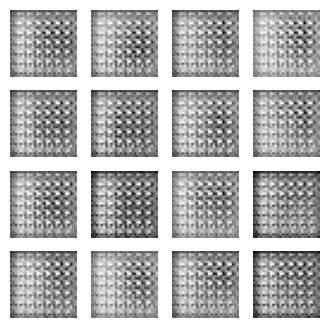

Time for epoch #101 is 534.57s
Discriminator loss: 1.4616
Generator loss: 0.7047
Start epoch #102 (69 steps)...


KeyboardInterrupt: 

In [69]:
training_history_current = train(
    train_dataset,
    epochs=epochs_num,
    start_epoch=start_epoch
)

## <span style="color: grey;">Analyzing training history

In [0]:
training_history['generator']['loss'] += training_history_current['generator']['loss']
training_history['discriminator']['loss'] += training_history_current['discriminator']['loss']

Here a graph is displayed showing the loss at each epoch

In [0]:
def render_training_history(training_history):
    generator_loss = training_history['generator']['loss']
    discriminator_loss = training_history['discriminator']['loss']

    plt.figure(figsize=(14, 4))

    plt.subplot(1, 2, 1)
    plt.title('Generator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(generator_loss, label='Generator loss')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Discriminator Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(discriminator_loss, label='Discriminator loss')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.show()

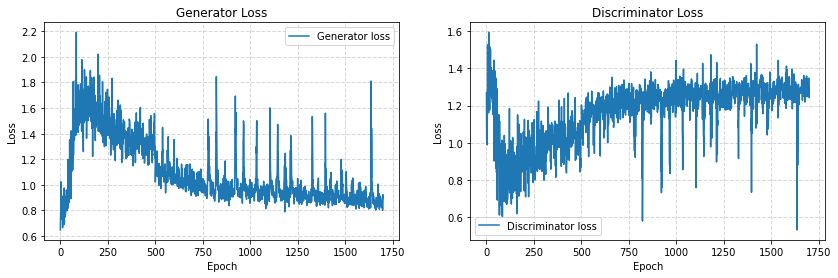

In [170]:
render_training_history(training_history)

In [0]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## <span style="color: grey;">Save models

In [0]:
generator_model.save('generator_model.h5', save_format='h5')
discriminator_model.save('discriminator_model.h5', save_format='h5')

In [107]:
# Restore models from files if needed.
# generator_model.load_weights('./generator_model.h5')
# discriminator_model.load_weights('./discriminator_model.h5')

## <span style="color: grey;">Zip all preview images

In [96]:
def zip_image_previews():
    images_previews_path = IMAGES_PREVIEW_PATH
    images_previews_zip_name = 'images_previews.zip'

    zipped_files_num = 0
    with zipfile.ZipFile(images_previews_zip_name, mode='w') as zip_obj:
        for folder_name, subfolders, filenames in os.walk(images_previews_path):
            for filename in filenames:
                zipped_files_num += 1
                file_path = os.path.join(folder_name, filename)
                zip_obj.write(file_path, os.path.basename(file_path))
    print('Zipped {} files to '.format(zipped_files_num), images_previews_zip_name)

In [178]:
zip_image_previews()

Zipped 2600 files to  images_previews.zip


## <span style="color: grey;">Trying models

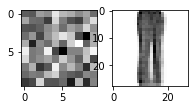

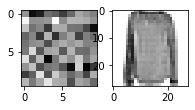

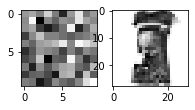

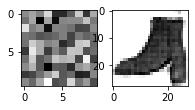

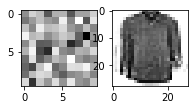

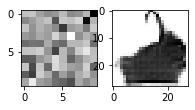

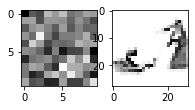

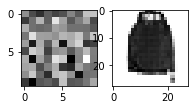

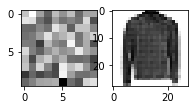

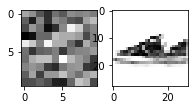

In [118]:
test_examples_num = 10

noise_images = tf.random.normal([test_examples_num, 100])
generated_images = generator_model(noise_images, training=False)

for example_num in range(test_examples_num):
    plt.figure(figsize=(3, 3))

    plt.subplot(1, 2, 1)
    plt.imshow(np.reshape(noise_images[example_num], (10, 10)), cmap=plt.cm.binary)

    plt.subplot(1, 2, 2)
    plt.imshow(generated_images[example_num, :, :, 0], cmap=plt.cm.binary)

## <span style="color: grey;">Create a GIF

In [97]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open('{}image_at_epoch_{:04d}.png'.format(IMAGES_PREVIEW_PATH, epoch_no))

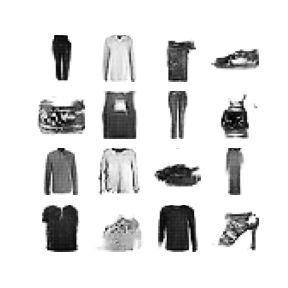

In [99]:
display_image(EPOCHS)

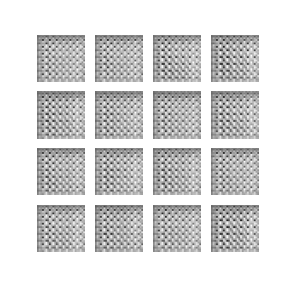

In [123]:
anim_file = 'clothes_generation_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob(IMAGES_PREVIEW_PATH + 'image*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

display.Image(filename=anim_file)

![Clothes Generation with DCGAN demo](https://raw.githubusercontent.com/trekhleb/machine-learning-experiments/master/demos/src/images/clothes_generation_dcgan.gif)

## <span style="color: grey;">Converting the model to web-format

<span style="color: grey;">To use this model on the web we need to convert it into the format that will be understandable by [tensorflowjs](https://www.tensorflow.org/js). To do so we may use [tfjs-converter](https://github.com/tensorflow/tfjs/tree/master/tfjs-converter) as following:

<span style="color: grey;">
```
tensorflowjs_converter --input_format keras \
  ./experiments/clothes_generation_dcgan/generator_model.h5 \
  ./demos/public/models/clothes_generation_dcgan
```
</span>

<span style="color: grey;">You find this experiment in the [Demo app](https://trekhleb.github.io/machine-learning-experiments) and play around with it right in you browser to see how the model performs in real life.

# Testing out the Model
In this section I will be trying out the model created in this notebook

# GAN Project: Handwritten text generation